# PCA on Senator Trades and Market Sector Data

In [970]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from numpy import linalg as la
from datetime import datetime

import yfinance as yf
from yahooquery import Ticker

In [971]:
%cd "C:\Users\Jared\Desktop\Columbia\Statistical Finance\Final Project"

C:\Users\Jared\Desktop\Columbia\Statistical Finance\Final Project


## Senator Data

In [972]:
data = pd.read_csv('Stock_Trading_Data.csv')

## Descriptive Stats

In [973]:
print(f'DataFrame shape: {data.shape}')
print(f'Num of senators: {data["senator"].unique().size}')
print(f'Num of securities: {data["ticker"].unique().size}')
print('\n')
print(data.dtypes)
# data.head()

DataFrame shape: (8265, 16)
Num of senators: 54
Num of securities: 1023


senator                    object
party                     float64
sex                         int64
trade_date                 object
owner                      object
ticker                     object
type                       object
trade_amount_max          float64
trade_amount_min          float64
buy_one_year_change       float64
one_mo_vtsax_change       float64
one_year_vtsax_change     float64
buy_compare_one_year      float64
one_month_sell            float64
one_month_sell_compare    float64
weight                    float64
dtype: object


In [974]:
unique_lists = []
unique_lists_no_na = []
for col in data.columns:
    
    # find unique categories for each variable
    unique = data[col].unique()
    if unique.size < 20:
        unique_lists.append((col, list(unique)))
        
    # same thing, but drop na's
    data_col = data[col].dropna()
    unique = data_col.unique()
    if unique.size < 20:
        unique_lists_no_na.append((col, list(unique)))
        
unique_lists_no_na

[('party', [1.0, 0.0]),
 ('sex', [1, 0]),
 ('owner', ['Spouse', 'Child', 'Self', 'Joint']),
 ('type', ['Purchase', 'Sale']),
 ('trade_amount_max',
  [50000.0,
   15000.0,
   100000.0,
   250000.0,
   1000000.0,
   5000000.0,
   500000.0,
   25000000.0,
   50000000.0]),
 ('trade_amount_min',
  [15000.0,
   1000.0,
   50000.0,
   100000.0,
   500000.0,
   1000000.0,
   250000.0,
   5000000.0,
   25000000.0]),
 ('weight', [4.0599999, 1.0, 9.3800001, 21.879999, 31.25])]

## With Metadata

In [975]:
data2 = pd.read_csv('updated senate dataset with stock info.csv')

In [976]:
data2.groupby('senator')['Symbol'].unique()

senator
A. MitchellMcconnell                                   [WFC, VMC, IR, --]
Angus King              [--, VZ, SLB, XOM, COP, WAT, CMCSA, AMZN, UTX,...
Benjamin Cardin                                       [--, NGG, OLN, MET]
Chris VanHollen                        [YUMC, YUM, VZ, PEP, JNJ, GE, nan]
Christopher Coons                                  [--, MSFT, AAPL, NFLX]
Cory Booker             [NKE, IRM, IBM, FB, AMZN, AAPL, DISH, AMT, EBA...
Daniel Sullivan         [RPM, WCMIX, MALOX, GTCSX, TSCIX, VPMAX, IWF, ...
David Perdue            [--, DOW, EEM, IDV, IWM, SPY, VEA, VOO, CAIFX,...
Diane Feinstein                                                    [ALLO]
Dianne Feinstein                                                    [nan]
Gary Peters             [STAG, AEP, --, TFC, TOT, SHW, GIS, GE, nan, C...
Jacklyn Rosen                                    [PFE, IR, VFC, APC, NVS]
James Inhofe            [CRSP, BLK, AAPL, AMZN, BAM, nan, MSFT, PYPL, ...
Jeanne Shaheen                

## Preprocessing

In [977]:
senate = data.copy()
senate = senate[['senator', 'trade_date', 'party', 'owner', 'ticker', 'type', 'trade_amount_max', 'trade_amount_min']]
senate = senate.dropna()
senate['trade_date'] = senate['trade_date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))
senate = senate.set_index('trade_date')
senate = senate.sort_index(ascending=True)
senate = senate[senate['ticker'] != '--']

In [978]:
senate_tickers = senate['ticker'].unique().tolist()
senate_tickers = sorted(senate_tickers)

## Price Downloads

In [979]:
# nasdaq tickers from official screener
symbols = pd.read_csv('nasdaq_screener_1669854569804.csv')['Symbol'].astype(str).tolist()

In [980]:
downloads = [i for i in senate_tickers if i in symbols]
delisted = [i for i in senate_tickers if i not in symbols]

In [981]:
print(len(senate_tickers))
print(len(downloads))
print(len(delisted))

1016
633
383


In [982]:
senate_ticker_mask = senate['ticker'].apply(lambda t: t in downloads)
senate_searchable = senate[senate_ticker_mask]

In [983]:
tickers_download = Ticker(downloads, asynchronous=True, retry=20, status_forcelist=[404, 429, 500, 502, 503, 504], period='max')

### The Actual Download

In [984]:
%%time
prices_download = tickers_download.history(period = 'max')

Wall time: 50 s


In [985]:
prices = prices_download.reset_index()[['symbol', 'date', 'adjclose']]
prices = prices.pivot(index='date', columns='symbol', values='adjclose')
prices = prices.loc[min(senate.index):max(senate.index)]
prices.index = pd.to_datetime(prices.index)
prices_no_na = prices.fillna(0)

C:\Users\Jared\anaconda3\lib\site-packages\pandas\core\algorithms.py:1541: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return arr.searchsorted(value, side=side, sorter=sorter)  # type: ignore[arg-type]
C:\Users\Jared\anaconda3\lib\site-packages\pandas\core\indexes\base.py:3629: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.get_loc(casted_key)


In [986]:
template = pd.DataFrame(index = pd.date_range(start='2012-06-14', end='2021-01-29'), columns = ['dummy'], data = np.ones(pd.date_range(start='2012-06-14', end='2021-01-29').size))
prices_full = pd.merge(template, prices_no_na, left_index = True, right_index = True, how = 'outer').ffill(axis = 0).fillna(0).drop(columns = ['dummy'])

## Senator Wealth and Trade Size Weights

In [987]:
congress_wealth = pd.read_csv("congress wealth.csv")
senate_wealth = congress_wealth[congress_wealth['Chamber'] == 'Senate'].loc[:,['Name','Average']]
senate_wealth = senate_wealth.rename(columns = {'Average':'net_worth'})

In [988]:
senate_wealth["Name"] = senate_wealth["Name"].apply(lambda s: re.sub(r' \([-\w]*\)','',s).strip())
senate['senator'] = senate['senator'].apply(lambda s: 'Mitch McConnell' if s == 'A. MitchellMcconnell' else s)

In [989]:
senate_wealth = senate_wealth.sort_values(ascending = False, by = 'net_worth')
senate_wealth = senate_wealth[senate_wealth['net_worth'] > 0]
print(f"Senators with net worth data, where net worth is positive: {senate_wealth.shape[0]}")

Senators with net worth data, where net worth is positive: 75


In [990]:
first_quartile = senate_wealth['Name'].iloc[0:19].reset_index(drop = True)
second_quartile = senate_wealth['Name'].iloc[19:38].reset_index(drop = True)
third_quartile = senate_wealth['Name'].iloc[38:57].reset_index(drop = True)
fourth_quartile = senate_wealth['Name'].iloc[57:75].reset_index(drop = True)

In [991]:
first_quartile = pd.concat([first_quartile, pd.Series(name = 'trade_size_weight', data = np.full(19, 4/5))], axis = 1)
second_quartile = pd.concat([second_quartile, pd.Series(name = 'trade_size_weight', data = np.full(19, 3/5))], axis = 1)
third_quartile = pd.concat([third_quartile, pd.Series(name = 'trade_size_weight', data = np.full(19, 2/5))], axis = 1)
fourth_quartile = pd.concat([fourth_quartile, pd.Series(name = 'trade_size_weight', data = np.full(19, 1/5))], axis = 1)

In [992]:
trade_size_weights = pd.concat([first_quartile, second_quartile, third_quartile, fourth_quartile], axis = 0)
trade_size_weights = trade_size_weights.dropna()

In [993]:
senate_wealth['starting_amount'] = senate_wealth['net_worth'] / 2
senate_wealth = pd.merge(senate_wealth, trade_size_weights, left_on = 'Name', right_on = 'Name', how = 'inner')
senate_wealth.index = senate_wealth['Name']
senate_wealth.index.name = 'senator'
senate_wealth = senate_wealth.drop(columns = ['Name'])

## Create Senator Portfolio Time Series

In [994]:
senate['trade_amount_avg'] = (senate['trade_amount_min'] + senate['trade_amount_max']) / 2
senate_searchable['trade_amount_avg'] = (senate_searchable['trade_amount_min'] + senate_searchable['trade_amount_max']) / 2

C:\Users\Jared\AppData\Local\Temp\ipykernel_26736\2695361581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senate_searchable['trade_amount_avg'] = (senate_searchable['trade_amount_min'] + senate_searchable['trade_amount_max']) / 2


In [995]:
s1 = set(senate['senator'].unique().tolist())
s2 = set(senate_wealth.index.tolist())
list_of_senators_with_information = list(s1.intersection(s2))

In [996]:
list_of_senators_with_information

['Roy Blunt',
 'Susan Collins',
 'John Hoeven',
 'Cory Booker',
 'Mark Warner',
 'Mitch McConnell',
 'John Cornyn',
 'Maria Cantwell',
 'Tina Smith',
 'Tammy Duckworth',
 'Michael Bennet',
 'Sheldon Whitehouse',
 'Gary Peters',
 'Jerry Moran',
 'David Perdue',
 'Richard Burr',
 'Patty Murray',
 'Ron Wyden',
 'Pat Roberts']

In [997]:
list_of_senators = list_of_senators_with_information#senate_wealth.index.tolist()#senate['senator'].unique().tolist()

list_of_senator_series = []
list_of_position_dfs = []
list_of_change_dfs = []
for senator_name in list_of_senators:

    senator_data = senate_searchable[senate_searchable['senator'] == senator_name]

    trade_dates = []
    list_of_position_dicts = []
    list_of_values = []
    for date in senator_data.index.unique().tolist():
        date_copy = date
        
        # were there multiple events for this day
        data_on_date = senator_data.loc[[date]]    
        num_events_on_date = data_on_date.shape[0]

        # establish dict for the day
        if list_of_position_dicts:
            position_dict_on_date = list_of_position_dicts[-1].copy()
        else:
            position_dict_on_date = {}
            
        # loop through every event for this day
        value_on_date = 0
        for i in range(num_events_on_date):
            
            # order details: what was it, buy or sell, and how much (next block)?
            ticker_on_date = data_on_date.iloc[i]['ticker']
            valence_on_date = (1 if data_on_date.iloc[i]['type'] == 'Purchase' else -1)
            
            # "how much" is determined by a weighted average of the max possible traded and the min possible traded
            trade_amount_min = data_on_date['trade_amount_min'].iloc[i]
            trade_amount_max = data_on_date['trade_amount_max'].iloc[i]
            min_weight = 1 - senate_wealth.loc[senator_name, 'trade_size_weight']
            max_weight = senate_wealth.loc[senator_name, 'trade_size_weight']
            position_on_date = trade_amount_min*min_weight + trade_amount_max*max_weight
            
            # update dict for the day
            if ticker_on_date not in position_dict_on_date:
                position_dict_on_date[ticker_on_date] = 0
            position_dict_on_date[ticker_on_date] = position_dict_on_date[ticker_on_date] + valence_on_date*position_on_date
            
            # move forward in time
            while date not in prices.index:
                date += pd.to_timedelta(1, unit='d')
            value_from_event = prices.loc[date][ticker_on_date]*valence_on_date*position_on_date
            value_on_date += value_from_event
        
        # append to lists
        date = date_copy
        trade_dates.append(date)
        list_of_position_dicts.append(position_dict_on_date)
        list_of_values.append(value_on_date)
        
        # for purchases (change in positions)
        df = pd.DataFrame(index = pd.Series(name = senator_name, data = trade_dates), data = list_of_position_dicts)
        change_df = (df - df.shift(1).fillna(0)).fillna(0)
        
    senator_series = pd.Series(name = senator_name, index = trade_dates, data = list_of_values, dtype = float).dropna()
    list_of_senator_series.append(senator_series)
    list_of_position_dfs.append(df.fillna(0))
    list_of_change_dfs.append(change_df)

In [998]:
position_dict = {}
for df in list_of_position_dfs:
    position_dict[df.index.name] = df

In [999]:
list_of_cash_balances = []

# loop through for each senator
for df in list_of_change_dfs:
    
    senator_name = df.index.name
    dates = df.index
    
    trade_size_matrix = df.values
    price_matrix_transpose = prices_full.loc[df.index.tolist()][df.columns.tolist()].T.values
    
    trade_value_matrix = np.matmul(trade_size_matrix, price_matrix_transpose) # WRONG< NEED TO MULTIPLY WHOLE THING
    trade_value_changes = trade_value_matrix.diagonal() # only relevant when dates match, therefore diagonal
    total_value_traded_arr = trade_value_changes.cumsum()
    
    total_value_traded = pd.Series(name = senator_name, index = dates, data = total_value_traded_arr)
    starting_balance = senate_wealth.loc[senator_name,'starting_amount']
    individual_senator_balances = starting_balance - total_value_traded
    
    list_of_cash_balances.append(individual_senator_balances)
    
cash_balances = pd.concat(list_of_cash_balances, axis = 1)
cash_balances.iloc[0,:] = senate_wealth['starting_amount'][list_of_senators_with_information]
cash_balances = cash_balances.ffill()

In [1000]:
list_of_portfolio_values = []

for df in list_of_position_dfs:
    
    senator_name = df.index.name
    
    df_all_dates = pd.merge(date_template, df, left_index = True, right_index = True, how = 'outer') ## LOOOOK HERE
    df_all_dates = df_all_dates.drop(columns = ['dummy']).ffill().fillna(0)

    position_size_matrix = df_all_dates.values
    price_matrix_transpose = prices_full.loc[:,df.columns.tolist()].T.values # WRONG< NEED TO MULTIPLY WHOLE THING
    
    position_value_matrix = np.matmul(position_size_matrix, price_matrix_transpose)
    position_value_arr = position_value_matrix.diagonal()

    position_values = pd.Series(name = senator_name, index = df_all_dates.index, data = position_value_arr)
    list_of_portfolio_values.append(position_values)

portfolio_values_apart_from_cash = pd.concat(list_of_portfolio_values, axis = 1)  
portfolio_values_apart_from_cash = portfolio_values_apart_from_cash.ffill().fillna(0)

Reshape

In [1001]:
cash_balances_full = pd.merge(template, cash_balances, left_index = True, right_index = True, how = 'outer').drop(columns = ['dummy'])
cash_balances_full.iloc[0,:] = senate_wealth['starting_amount'][list_of_senators_with_information]
cash_balances_full = cash_balances_full.ffill()

Aggregate Cash and Non-Cash Portfolio Items

In [1002]:
senator_portfolio_values = None
if cash_balances_full.shape == portfolio_values_apart_from_cash.shape:
    senator_portfolio_values = cash_balances_full + portfolio_values_apart_from_cash

## Export

In [1003]:
from pathlib import Path  
filepath = Path('Senator Time Series/Senator Portfolio Time Series.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
senator_portfolio_values.to_csv(filepath)

## Visualize

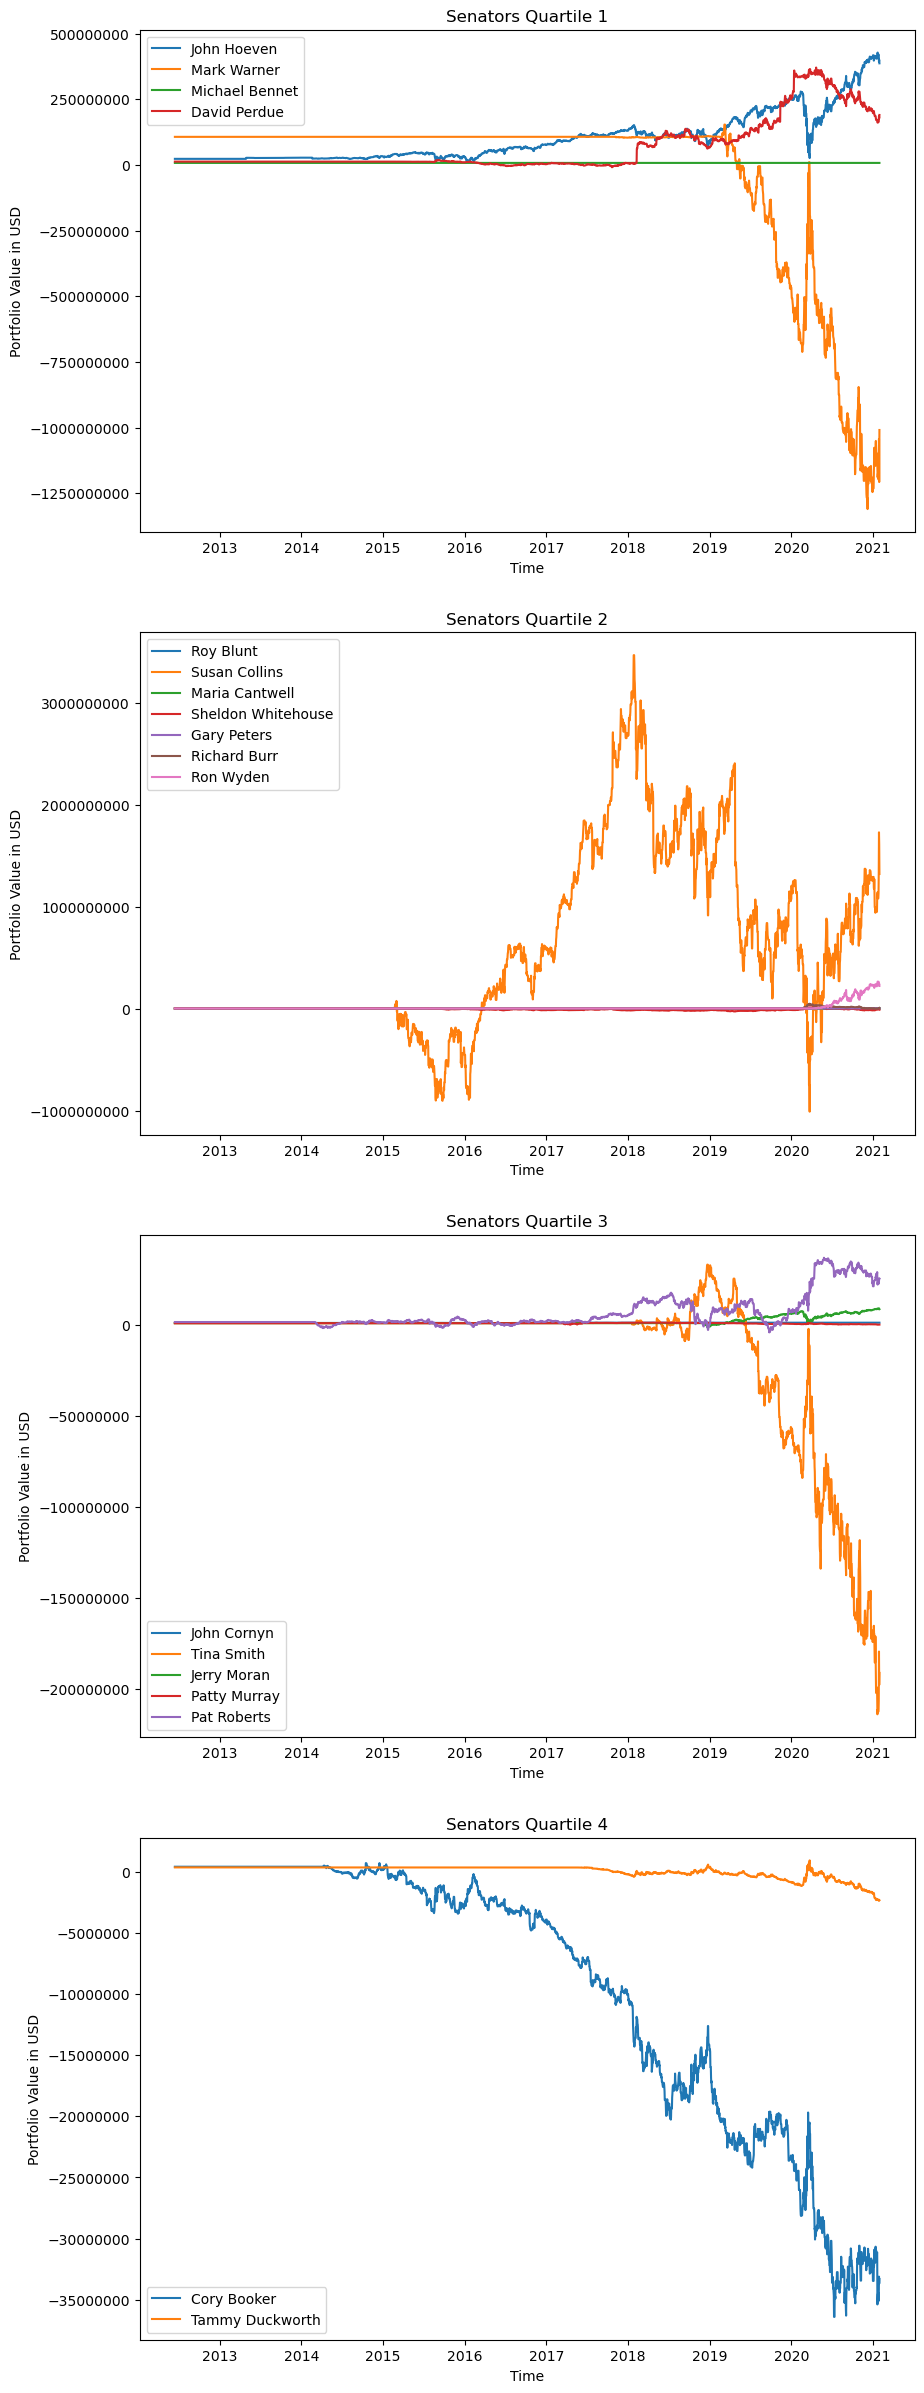

In [1004]:
q1 = []
q2 = []
q3 = []
q4 = []
final_senators = senator_portfolio_values.columns.unique()
for senator in final_senators:
    if senator in first_quartile['Name'].tolist():
        q1.append(senator)
    if senator in second_quartile['Name'].tolist():
        q2.append(senator)
    if senator in third_quartile['Name'].tolist():
        q3.append(senator)
    if senator in fourth_quartile['Name'].tolist():
        q4.append(senator)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

fig = plt.figure(figsize=(10, 30))

quartiles = [q1,q2,q3,q4]
i = 1
for quartile in quartiles:
    ax = fig.add_subplot(4, 1, i)
    
    for senator_name in quartile:
        if senator_name == 'Mark Warner':
            ax.plot(senator_portfolio_values[senator_name].iloc[:,0])
        else:
            ax.plot(senator_portfolio_values[senator_name], label = senator_name)

    ax.set_xlabel('Time')
    ax.set_ylabel('Portfolio Value in USD')
    ax.set_title(f'Senators Quartile {i}')
    ax.ticklabel_format(style = 'plain', axis = 'y')
    ax.legend(quartile)    
    
    i += 1
    
plt.show()

q1.remove('Mark Warner')
q3.remove('Tina Smith')
q4.remove('Cory Booker')
q4.remove('Tammy Duckworth')

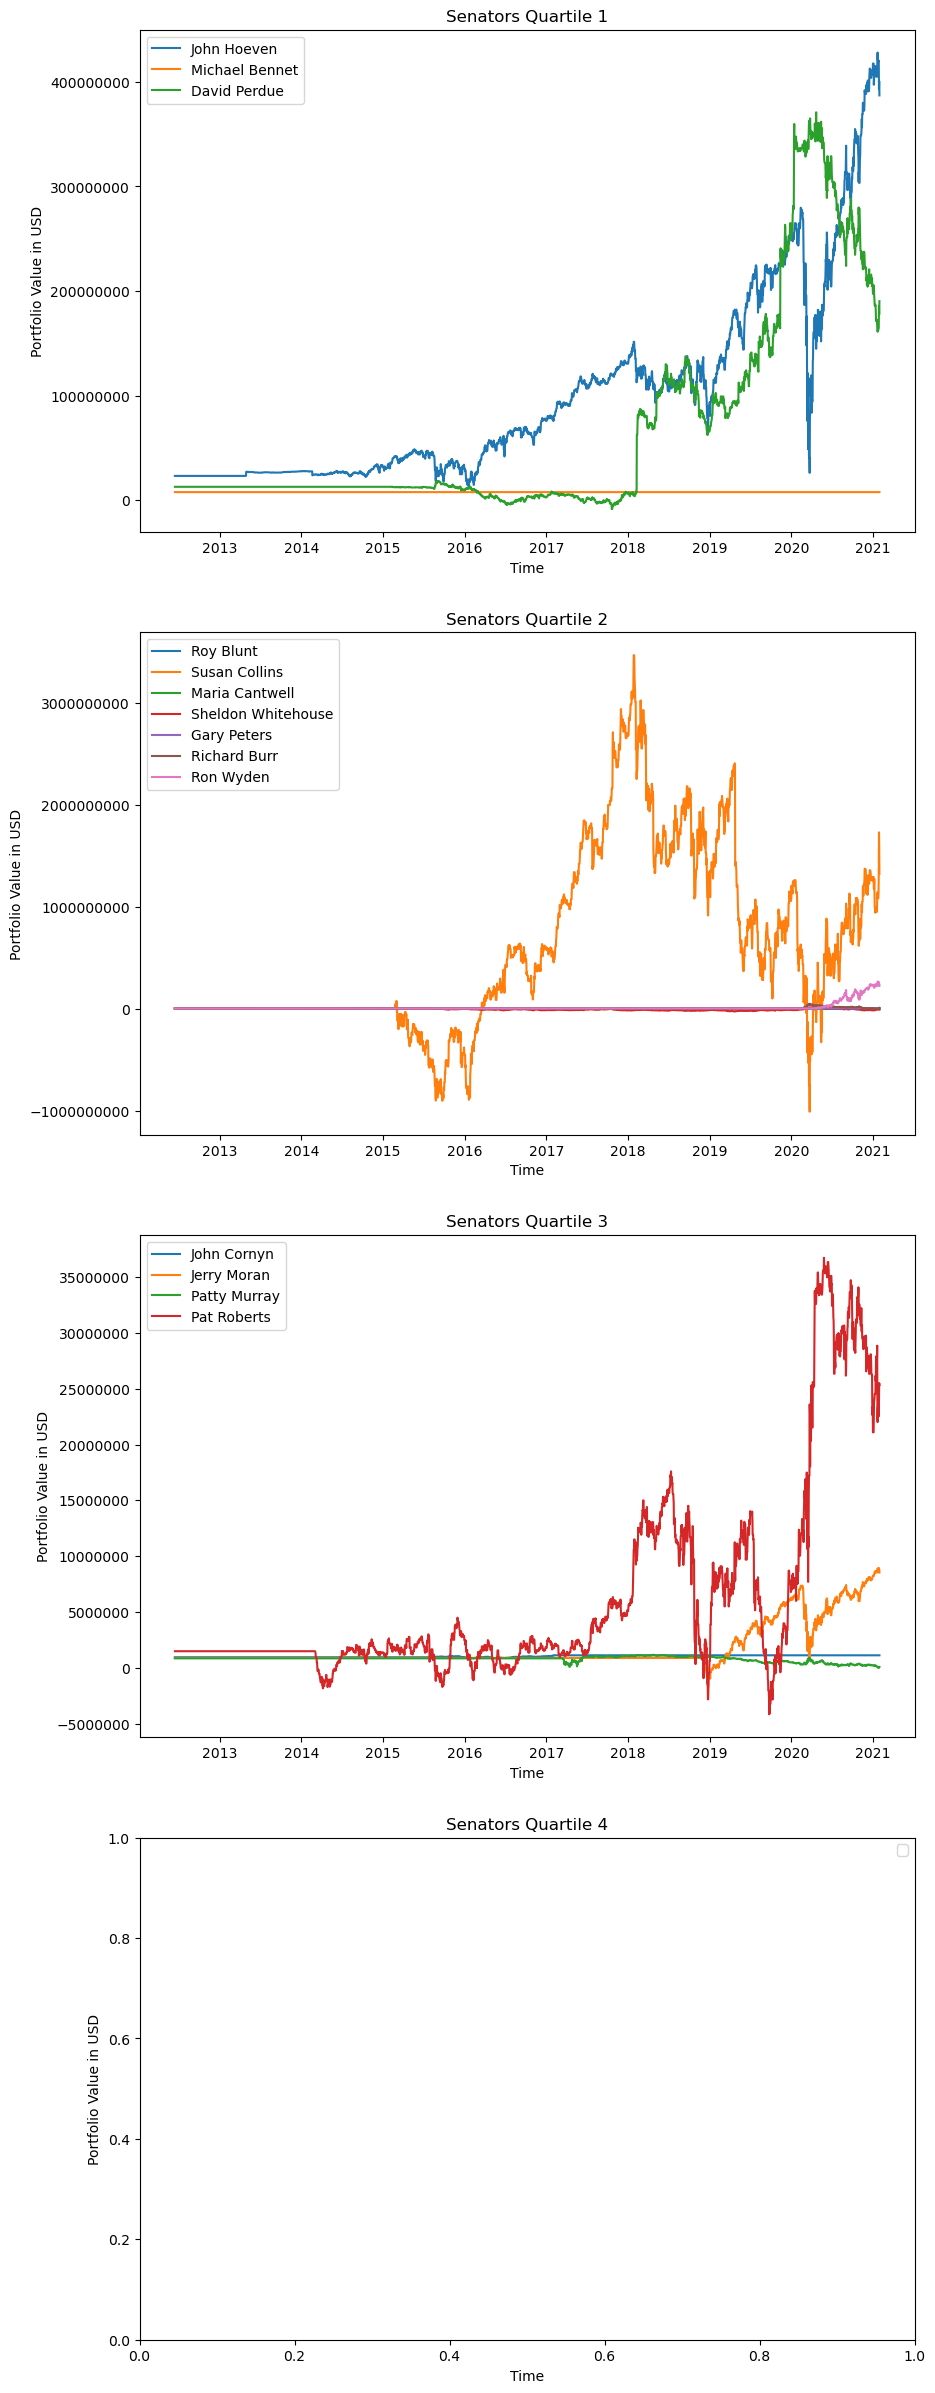

In [1005]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

fig = plt.figure(figsize=(10, 30))

quartiles = [q1,q2,q3,q4]
i = 1
for quartile in quartiles:
    ax = fig.add_subplot(4, 1, i)
    
    for senator_name in quartile:
        if senator_name == 'Mark Warner':
            ax.plot(senator_portfolio_values[senator_name].iloc[:,0])
        else:
            ax.plot(senator_portfolio_values[senator_name], label = senator_name)

    ax.set_xlabel('Time')
    ax.set_ylabel('Portfolio Value in USD')
    ax.set_title(f'Senators Quartile {i}')
    ax.ticklabel_format(style = 'plain', axis = 'y')
    ax.legend(quartile)    
    
    i += 1
    
plt.show()

In [1006]:
senators_with_purchase =  q1.copy()
senators_with_purchase.extend(q2)
senators_with_purchase.extend(q3)
senators_with_purchase.remove('Michael Bennet')

In [1007]:
portfolios_to_analyze = senator_portfolio_values[senators_with_purchase]

In [1008]:
portfolios_to_analyze

,John Hoeven,David Perdue,Roy Blunt,Susan Collins,Maria Cantwell,Sheldon Whitehouse,Gary Peters,Richard Burr,Ron Wyden,John Cornyn,Jerry Moran,Patty Murray,Pat Roberts
2012-06-14,23344784.500,12911298.000,2852255.000,2062021.500,2878254.000,3721814.000,2184052.500,3713106.500,3438512.500,942261.000,879769.500,843505.000,1483257.000
2012-06-15,23344784.500,12911298.000,2852255.000,2062021.500,2878254.000,3721814.000,2184052.500,3713106.500,3438512.500,942261.000,879769.500,843505.000,1483257.000
2012-06-16,23344784.500,12911298.000,2852255.000,2062021.500,2878254.000,3721814.000,2184052.500,3713106.500,3438512.500,942261.000,879769.500,843505.000,1483257.000
2012-06-17,23344784.500,12911298.000,2852255.000,2062021.500,2878254.000,3721814.000,2184052.500,3713106.500,3438512.500,942261.000,879769.500,843505.000,1483257.000
2012-06-18,23344784.500,12911298.000,2852255.000,2062021.500,2878254.000,3721814.000,2184052.500,3713106.500,3438512.500,942261.000,879769.500,843505.000,1483257.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,419321352.531,163783822.889,585701.023,1132476908.424,3083644.004,-5323033.645,6791470.686,3554702.823,265449330.862,1116856.280,8835738.702,6581.820,24109218.969
2021-01-26,420044496.520,164933827.670,469415.390,1337062868.414,3093044.006,-6010350.167,6729782.321,3721968.398,260824799.928,1116856.280,8952815.466,4987.581,22533093.553
2021-01-27,392955065.323,185694976.254,646353.528,1730604575.722,3104324.006,-8041501.335,6075429.000,6902748.242,231461829.374,1116856.280,8619359.133,25095.640,24467128.399
2021-01-28,400629380.861,177621735.030,545429.501,1613590417.633,3109024.002,-8669399.531,6427022.633,6261007.939,245329739.760,1116856.280,8799146.494,10484.337,25505927.682


## Standardizing Prices

In [918]:
mean_prices = portfolios_to_analyze.mean(axis = 0)
mean_prices_df = pd.concat([mean_prices] * portfolios_to_analyze.shape[0], axis = 1).T

In [919]:
std_prices = portfolios_to_analyze.std(axis = 0)
std_prices_df = pd.concat([std_prices] * portfolios_to_analyze.shape[0], axis = 1).T

In [925]:
transformed_prices = (portfolios_to_analyze.values - mean_prices_df.values)/std_prices_df.values
transformed_prices = pd.DataFrame(transformed_prices)

## Price to Returns

In [926]:
senator_returns = portfolios_to_analyze.pct_change(axis = 0)
senator_returns = senator_returns.fillna(0)

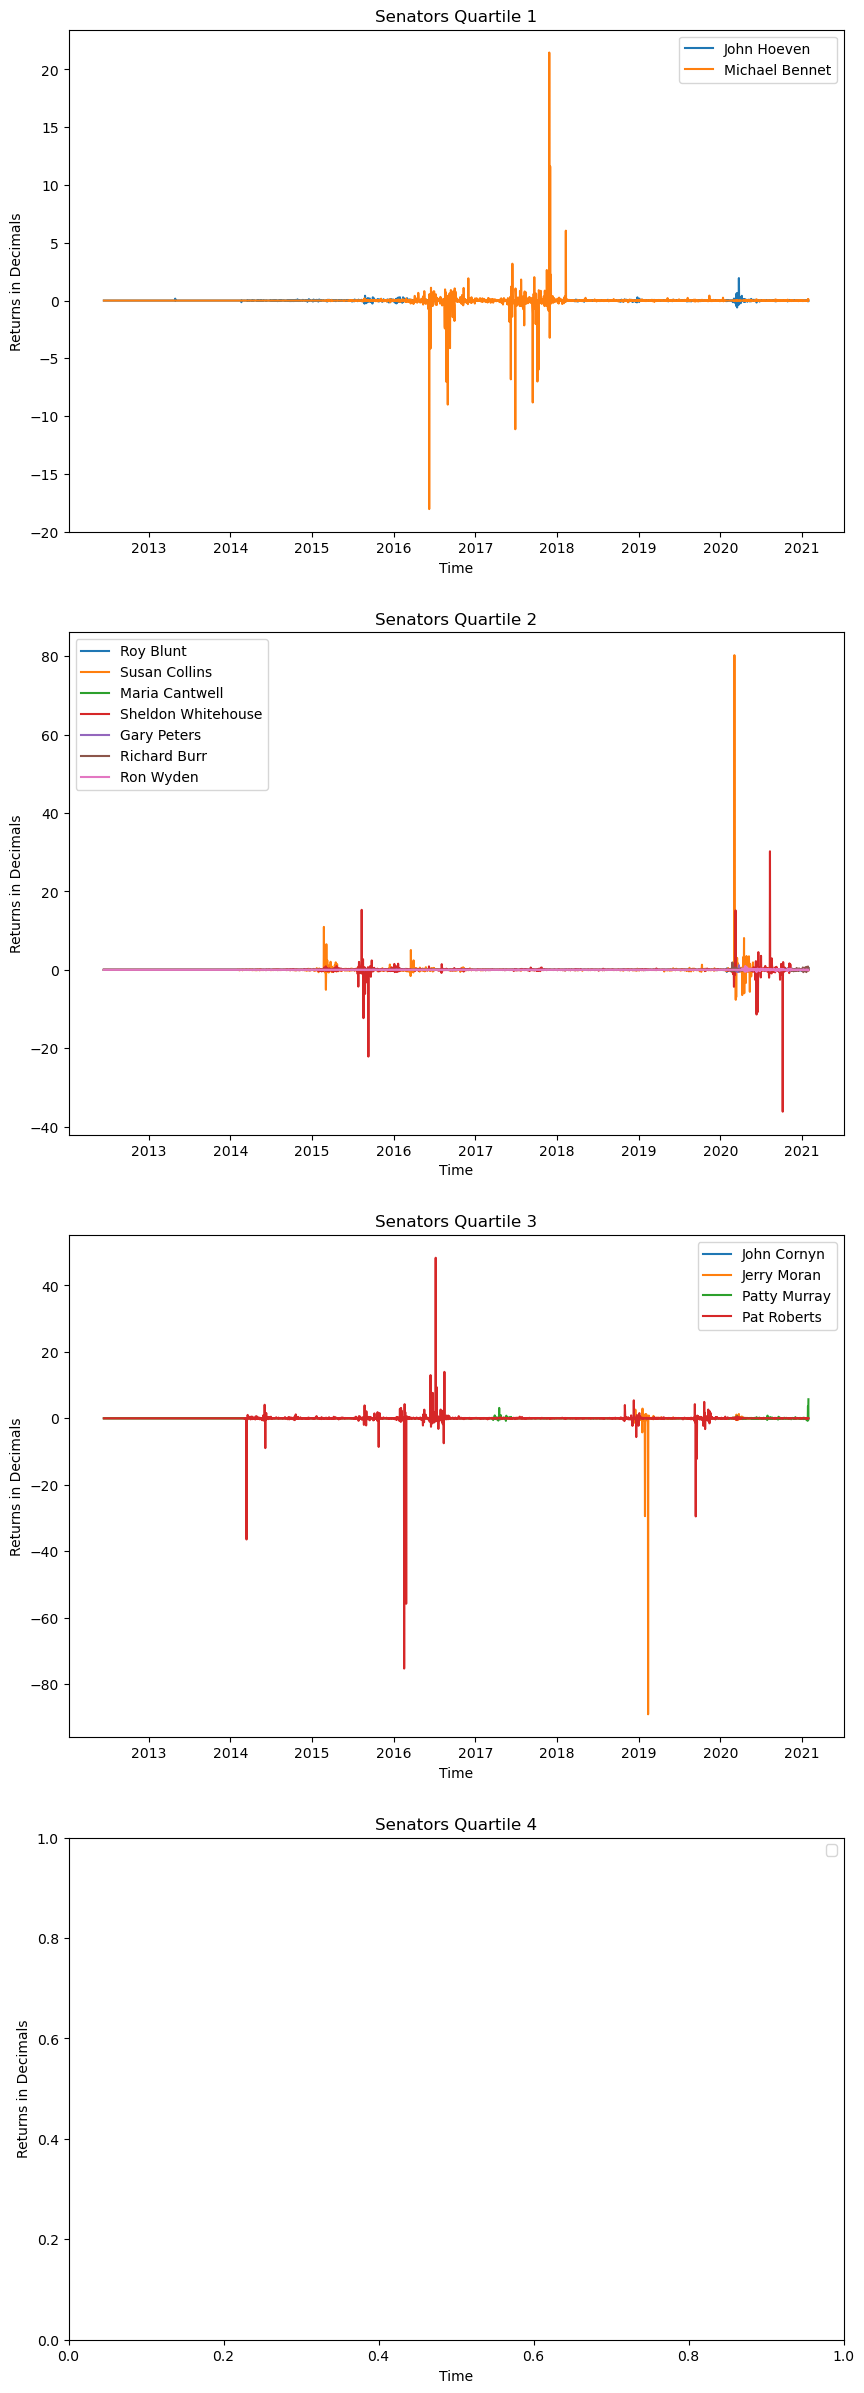

In [927]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

fig = plt.figure(figsize=(10, 30))

quartiles = [q1,q2,q3,q4]
i = 1
for quartile in quartiles:
    ax = fig.add_subplot(4, 1, i)
    
    for senator_name in quartile:
        if senator_name != 'Michael Bennet':
            if senator_name == 'Mark Warner':
                ax.plot(senator_returns[senator_name].iloc[:,0])
            else:
                ax.plot(senator_returns[senator_name], label = senator_name)

    ax.set_xlabel('Time')
    ax.set_ylabel('Returns in Decimals')
    ax.set_title(f'Senators Quartile {i}')
    ax.ticklabel_format(style = 'plain', axis = 'y')
    ax.legend(quartile)    
    
    i += 1
    
plt.show()

## Standardizing Returns

In [928]:
mean_returns = senator_returns.mean(axis = 0)
mean_returns_df = pd.concat([mean_returns] * senator_returns.shape[0], axis = 1).T

In [929]:
std_returns = senator_returns.std(axis = 0)
std_returns_df = pd.concat([std_returns] * senator_returns.shape[0], axis = 1).T

In [930]:
transformed_returns = (senator_returns.values - mean_returns_df.values)/std_returns_df.values
transformed_returns = pd.DataFrame(transformed_returns)

Standardized Returns

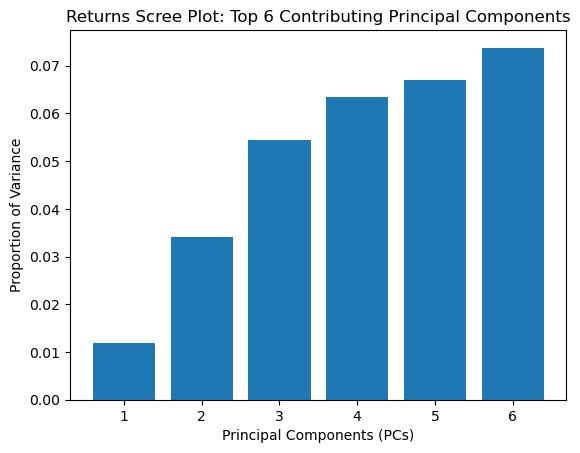

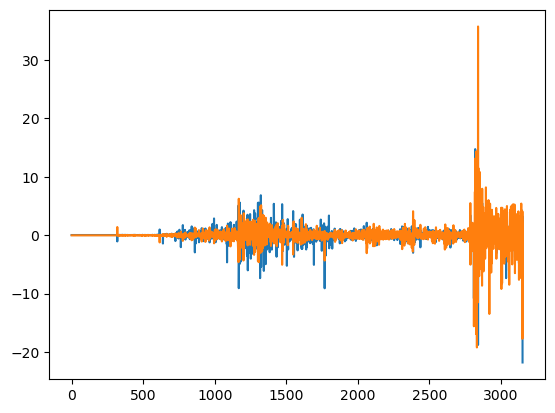

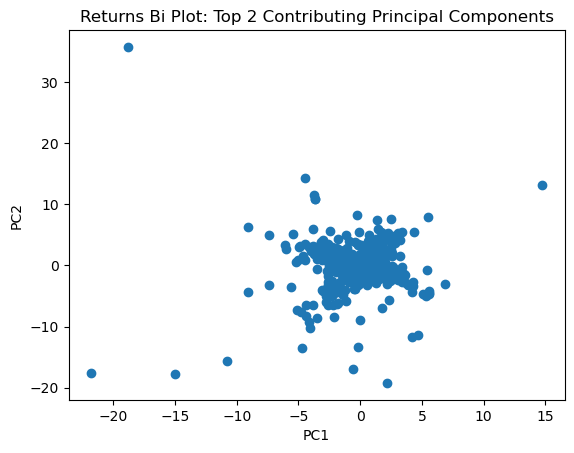

In [931]:
# covariance matrices are symmetric
# which implies eigenvec's form an *orthonomal* eigen change-of-basis matrix
cov = np.cov(transformed_returns, rowvar = False)
eigenval, eigenvec = la.eigh(cov)
eigenvec_inv = eigenvec.T

# anything past the first 5 PC's has a neglible contribution to the variance
proportion_var = eigenval / eigenval.sum()
plt.bar([1,2,3,4,5,6], height = proportion_var[:6])
plt.title("Returns Scree Plot: Top 6 Contributing Principal Components")
plt.xlabel("Principal Components (PCs)")
plt.ylabel("Proportion of Variance")
plt.show()

# pick the top 2 PC's for graphing bi-plot
top_vals = eigenval[[len(eigenval)-2,len(eigenval)-1]]
top_vecs = eigenvec[:,[len(eigenval)-2,len(eigenval)-1]]
top_vecs_inv = top_vecs.T

low_rank_approx = np.matmul(top_vecs_inv, transformed_returns.T).T
l1 = low_rank_approx.iloc[:,0].tolist()
l2 = low_rank_approx.iloc[:,1].tolist()

plt.plot(l1)
plt.plot(l2)
plt.show()

plt.plot(l1,l2, 'o')
plt.title("Returns Bi Plot: Top 2 Contributing Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Standardized Prices

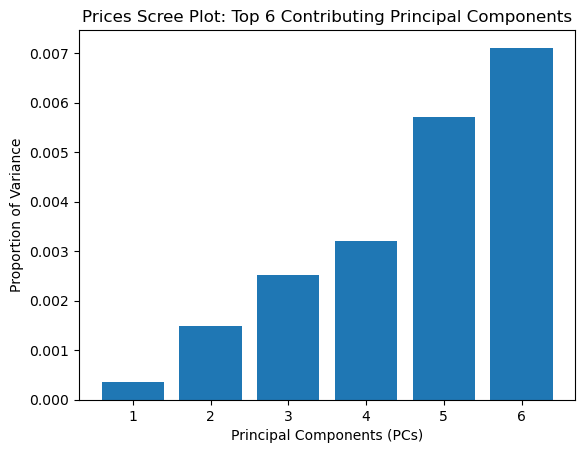

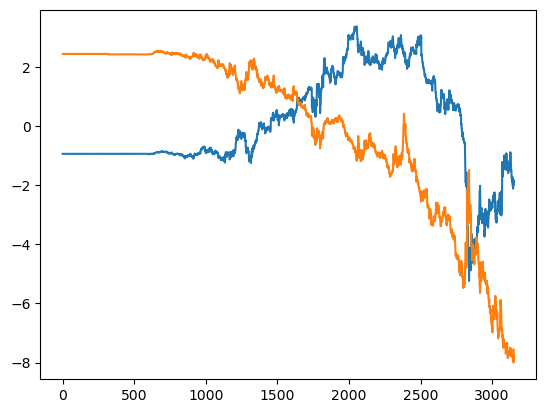

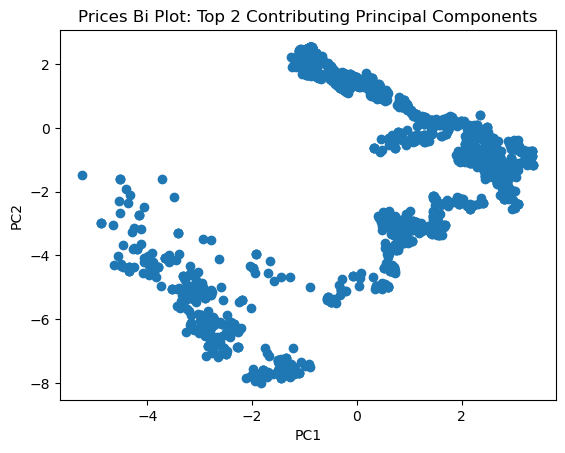

In [934]:
# covariance matrices are symmetric
# which implies eigenvec's form an *orthonomal* eigen change-of-basis matrix
cov = np.cov(transformed_prices, rowvar = False)
eigenval, eigenvec = la.eigh(cov)
eigenvec_inv = eigenvec.T 

# anything past the first 5 PC's has a neglible contribution to the variance
proportion_var = eigenval / eigenval.sum()
plt.bar([1,2,3,4,5,6], height = proportion_var[:6])
plt.title("Prices Scree Plot: Top 6 Contributing Principal Components")
plt.xlabel("Principal Components (PCs)")
plt.ylabel("Proportion of Variance")
plt.show()

# pick the top 2 PC's for graphing bi-plot
top_vals = eigenval[[len(eigenval)-2,len(eigenval)-1]]
top_vecs = eigenvec[:,[len(eigenval)-2,len(eigenval)-1]]
top_vecs_inv = top_vecs.T

low_rank_approx = np.matmul(top_vecs_inv, transformed_prices.T).T
l1 = low_rank_approx.iloc[:,0].tolist()
l2 = low_rank_approx.iloc[:,1].tolist()


plt.plot(l1)
plt.plot(l2)
plt.show()

plt.plot(l1,l2, 'o')
plt.title("Prices Bi Plot: Top 2 Contributing Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [1011]:
portfolios_to_analyze.values.T

array([[2.33447845e+07, 2.33447845e+07, 2.33447845e+07, ...,
        3.92955065e+08, 4.00629381e+08, 3.87012470e+08],
       [1.29112980e+07, 1.29112980e+07, 1.29112980e+07, ...,
        1.85694976e+08, 1.77621735e+08, 1.90343910e+08],
       [2.85225500e+06, 2.85225500e+06, 2.85225500e+06, ...,
        6.46353528e+05, 5.45429501e+05, 8.07737268e+05],
       ...,
       [8.79769500e+05, 8.79769500e+05, 8.79769500e+05, ...,
        8.61935913e+06, 8.79914649e+06, 8.53061669e+06],
       [8.43505000e+05, 8.43505000e+05, 8.43505000e+05, ...,
        2.50956404e+04, 1.04843373e+04, 7.34102757e+04],
       [1.48325700e+06, 1.48325700e+06, 1.48325700e+06, ...,
        2.44671284e+07, 2.55059277e+07, 2.53220149e+07]])

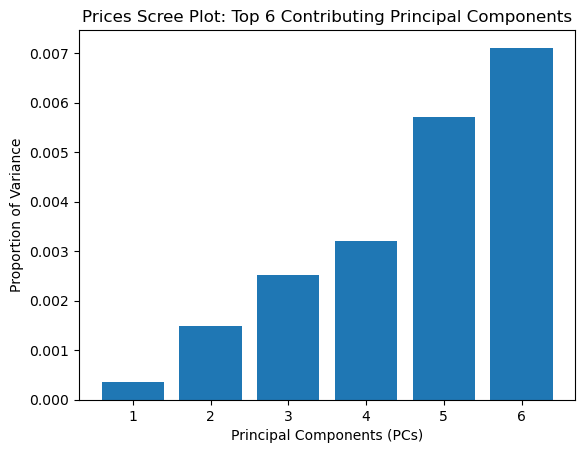

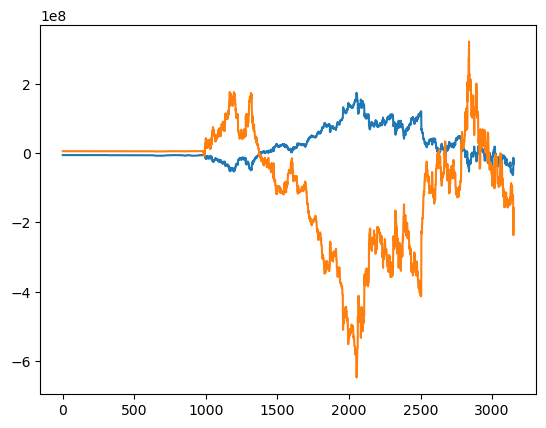

In [1026]:
# covariance matrices are symmetric
# which implies eigenvec's form an *orthonomal* eigen change-of-basis matrix
cov = np.cov(transformed_prices, rowvar = False)
eigenval, eigenvec = la.eigh(cov)
eigenvec_inv = eigenvec.T 

# anything past the first 5 PC's has a neglible contribution to the variance
proportion_var = eigenval / eigenval.sum()
plt.bar([1,2,3,4,5,6], height = proportion_var[:6])
plt.title("Prices Scree Plot: Top 6 Contributing Principal Components")
plt.xlabel("Principal Components (PCs)")
plt.ylabel("Proportion of Variance")
plt.show()

# pick the top 2 PC's for graphing bi-plot
top_vals = eigenval[len(eigenval)-7:len(eigenval)-1]
top_vecs = eigenvec[:,len(eigenval)-7:len(eigenval)-1]
top_vecs_inv = top_vecs.T

low_rank_approx = np.matmul(top_vecs_inv, portfolios_to_analyze.values.T).T
l1 = low_rank_approx[:,0].tolist()
l2 = low_rank_approx[:,1].tolist()
l3 = low_rank_approx[:,2].tolist()
l4 = low_rank_approx[:,3].tolist()
l5 = low_rank_approx[:,4].tolist()
l6 = low_rank_approx[:,5].tolist()

plt.plot(l1)
plt.plot(l2)
plt.show()

#plt.plot(l5,l6, 'o')
#plt.title("Prices Bi Plot: Top 2 Contributing Principal Components")
#plt.xlabel("PC1")
#plt.ylabel("PC2")
plt.show()

In [1025]:
filepath = Path('Senator Time Series/PCA Not Transformed Senator Portfolios.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
pd.DataFrame(columns = ['pc6','pc5','pc4','pc3','pc2','pc1',], data = low_rank_approx).to_csv(filepath)

## Applying PCA to Market Sector Data

In [933]:
def getYahooData(ticker, start, end, interval='1d'):
    # Download the ticker prices
    data = yf.download(ticker, start=start, end=end, interval=interval) 
    # Set the index to a datetime type
    data.index = pd.to_datetime(data.index)
    
    return data

In [18]:
vtsax_data = getYahooData("VTSAX", min(senate.index), max(senate.index), interval='1d')
spy_data = getYahooData("^GSPC", min(senate.index), max(senate.index), interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
